## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from neural_networks.fcrn import FCRN_A
from neural_networks.net_utils import predict_density_maps_and_get_counts
from utils.data.data_generator import DataGenerator
from utils.evaluation.evaluation import evaluation_results_as_dict
from utils.evaluation.evaluation import evaluation_results_as_df
from utils.input_output.io import load_images_and_density_maps
from utils.input_output.io import read_json, write_json
from utils.input_output.io import load_gt_counts
from utils.visualization.vis import plot_some_predictions
from utils.visualization.vis import plot_gt_vs_pred_counts

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

### Select the checkpoint file that you want to test/evaluate

In [4]:
checkpoint_filenames = sorted(os.listdir(config.CHECKPOINTS_PATH))
print(checkpoint_filenames)

['model.01-1.236.hdf5', 'model.02-1.089.hdf5', 'model.03-0.908.hdf5', 'model.04-1.087.hdf5', 'model.05-0.812.hdf5', 'model.06-0.963.hdf5', 'model.07-0.764.hdf5', 'model.08-0.905.hdf5', 'model.09-0.782.hdf5', 'model.10-0.902.hdf5', 'model.11-0.800.hdf5', 'model.12-0.685.hdf5', 'model.13-0.644.hdf5', 'model.14-0.651.hdf5', 'model.15-0.652.hdf5', 'model.16-0.613.hdf5', 'model.17-0.585.hdf5', 'model.18-0.579.hdf5', 'model.19-0.593.hdf5', 'model.20-0.606.hdf5', 'model.21-0.576.hdf5', 'model.22-0.633.hdf5', 'model.23-0.681.hdf5', 'model.24-0.574.hdf5', 'model.25-0.570.hdf5', 'model.26-1.009.hdf5', 'model.27-0.525.hdf5', 'model.28-0.523.hdf5', 'model.29-0.529.hdf5', 'model.30-0.545.hdf5', 'model.31-0.535.hdf5', 'model.32-0.507.hdf5', 'model.33-0.522.hdf5', 'model.34-0.857.hdf5', 'model.35-0.773.hdf5', 'model.36-0.531.hdf5', 'model.37-0.526.hdf5', 'model.38-0.524.hdf5', 'model.39-0.501.hdf5', 'model.40-0.501.hdf5', 'model.41-0.493.hdf5', 'model.42-0.498.hdf5', 'model.43-0.606.hdf5', 'model.44-

In [5]:
selected_checkpoint_filename = checkpoint_filenames[40]
print(f'selected checkpoint_filename: {selected_checkpoint_filename}')

selected checkpoint_filename: model.41-0.493.hdf5


In [6]:
epoch = selected_checkpoint_filename.split('.')[1].split('-')[0]
print('epoch:', epoch)

epoch: 41


In [7]:
# Set epoch and val loss
CHECKPOINT_FILENAME = f'{config.CHECKPOINTS_PATH}/{selected_checkpoint_filename}'
QUANTITATIVE_RESULTS_PATH = f'./{config.SUB_EXPERIMENT_NAME}/results/quantitative/epoch_{epoch}'

In [8]:
!rm -rf $QUANTITATIVE_RESULTS_PATH
os.makedirs(QUANTITATIVE_RESULTS_PATH)

## 2. Load the dataset

In [9]:
params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': False
}

In [10]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)
test_generator = DataGenerator(config.DATASET_PATH, 'test', **params)

In [11]:
train_gt_counts = load_gt_counts(config.TRAIN_GT_COUNT_PATH)
val_gt_counts = load_gt_counts(config.VAL_GT_COUNT_PATH)
test_gt_counts = load_gt_counts(config.TEST_GT_COUNT_PATH)

## 3. Load the best model

In [12]:
model = FCRN_A(pretrained_weights=CHECKPOINT_FILENAME)

## 4. Predict and evaluate

In [13]:
train_pred_counts = predict_density_maps_and_get_counts(model, train_generator,
                                                        config.DENSITY_MAP_MULTIPLICATION_FACTOR)
val_pred_counts = predict_density_maps_and_get_counts(model, val_generator,
                                                      config.DENSITY_MAP_MULTIPLICATION_FACTOR)
test_pred_counts = predict_density_maps_and_get_counts(model, test_generator,
                                                       config.DENSITY_MAP_MULTIPLICATION_FACTOR)

In [14]:
train_results = evaluation_results_as_dict(train_gt_counts, train_pred_counts, 'train')
val_results = evaluation_results_as_dict(val_gt_counts, val_pred_counts, 'val')
test_results = evaluation_results_as_dict(test_gt_counts, test_pred_counts, 'test')

df = evaluation_results_as_df(train_results, val_results, test_results,
                              config.ARCHITECTURE_NAME,
                              config.SUB_EXPERIMENT_NAME,
                              config.DATASET_NAME)

df.to_csv(f'{QUANTITATIVE_RESULTS_PATH}/results.csv', index=True)

df.head(3)

MAE  \
Architecture_Name Experiment_Name                                    Dataset_Name         Dataset_Split           
FCRN_A            shanghai_tech/part_b/sigma_10_loss_mse_full_img... shanghai_tech/part_b train           9.890   
                                                                                          val            16.935   
                                                                                          test           20.214   

                                                                                                           RMSE  \
Architecture_Name Experiment_Name                                    Dataset_Name         Dataset_Split           
FCRN_A            shanghai_tech/part_b/sigma_10_loss_mse_full_img... shanghai_tech/part_b train          12.617   
                                                                                          val            23.690   
                                                                                          test           30.973   

                                                                                                        Underestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name         Dataset_Split                 
FCRN_A            shanghai_tech/part_b/sigma_10_loss_mse_full_img... shanghai_tech/part_b train                1.790%   
                                                                                          val                  5.897%   
                                                                                          test                 7.453%   

                                                                                                        Overestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name         Dataset_Split                
FCRN_A            shanghai_tech/part_b/sigma_10_loss_mse_full_img... shanghai_tech/part_b train               6.199%   
                                                                                          val                 8.367%   
                                                                                          test                8.887%   

                                                                                                        Difference  
Architecture_Name Experiment_Name                                    Dataset_Name         Dataset_Split             
FCRN_A            shanghai_tech/part_b/sigma_10_loss_mse_full_img... shanghai_tech/part_b train             7.989%  
                                                                                          val              14.264%  
                                                                                          test             16.340%

## 5. Short analysis of evaluation results

shanghai_tech/part_b dataset

train set: 320 images
Underestimation in 73 images
Overestimation in 247 images
(GT stats)         counts per image: mean=123.78, std=96.00, min=12,    max=576
(Prediction stats) counts per image: mean=129.24, std=93.50, min=14.99, max=602.80

test set: 316 images
Underestimation in 98 images
Overestimation in 218 images
(GT stats)         counts per image: mean=123.70, std=95.00, min=9,    max=539
(Prediction stats) counts per image: mean=125.48, std=76.79, min=19.07, max=440.42


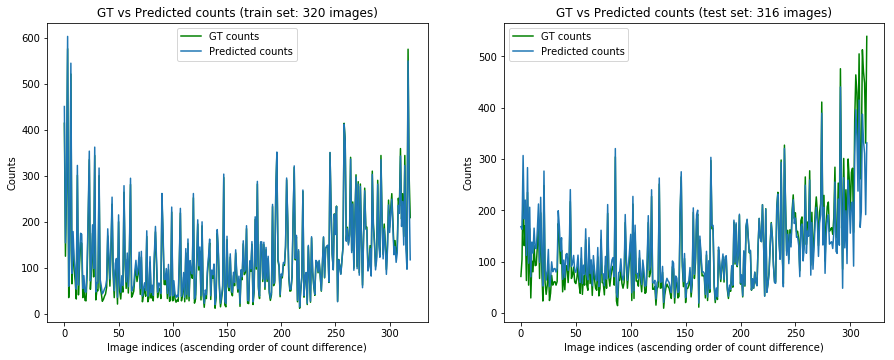

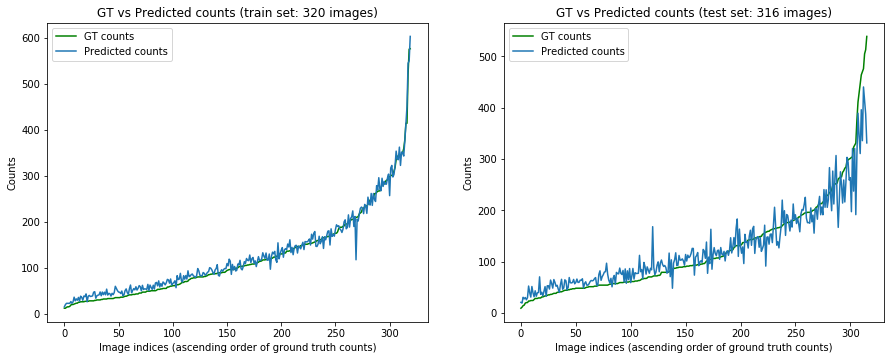

In [15]:
print(f'{config.DATASET_NAME} dataset')

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False,
                       criterion='gt', print_stats=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False,
                       criterion='gt', print_stats=False)

## 6. Look at some predictions (a small batch from the test set)

In [16]:
NUM_IMAGES = 3
test_images_batch, test_density_maps_batch = load_images_and_density_maps(config.TEST_PATH, NUM_IMAGES)
test_preds_batch = model.predict(np.array(test_images_batch)) / config.DENSITY_MAP_MULTIPLICATION_FACTOR

def small_desc(images_batch, title):
    print(title)
    print(len(images_batch),
          images_batch[0].shape, images_batch[0].dtype,
          images_batch[0].min(), images_batch[0].max())
    print()
    
small_desc(test_images_batch, 'test_images_batch')
small_desc(test_density_maps_batch, 'test_density_maps_batch')
small_desc(test_preds_batch, 'test_preds_batch')

test_images_batch
3 (768, 1024, 3) float64 0.0 1.0

test_density_maps_batch
3 (768, 1024) float64 0.0 0.0030818653049499165

test_preds_batch
3 (768, 1024, 1) float32 -0.00034188453 0.007859613



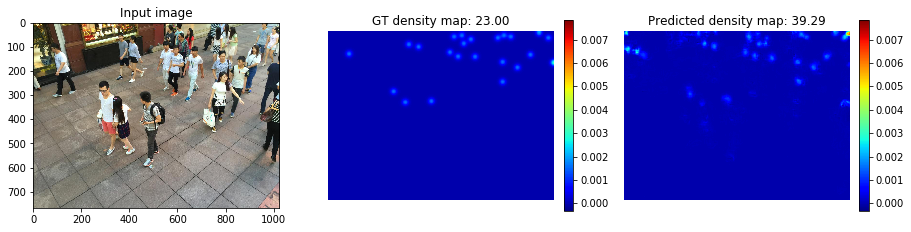

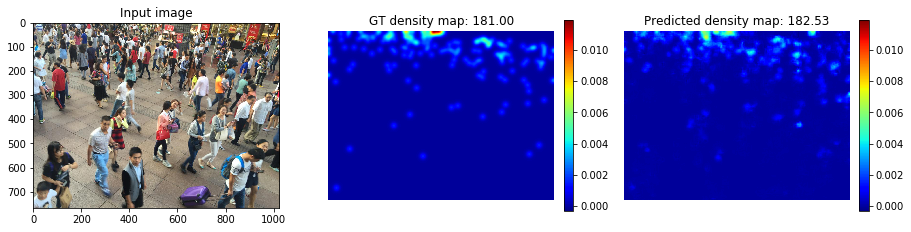

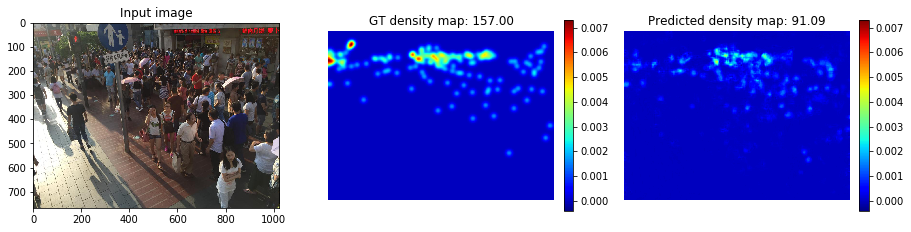

In [17]:
plot_some_predictions(test_images_batch, test_density_maps_batch, test_preds_batch)

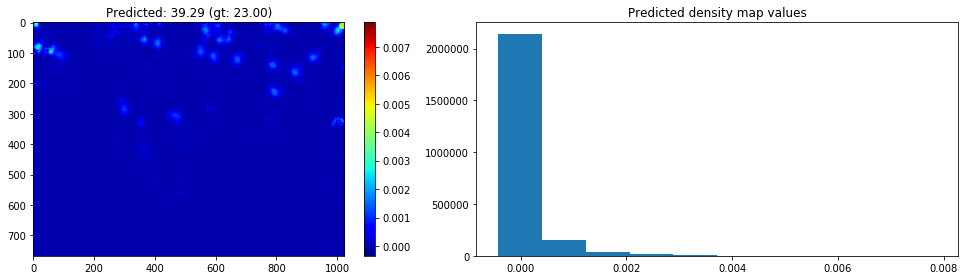

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title(f'Predicted: {test_preds_batch[0].sum():.2f} (gt: {test_density_maps_batch[0].sum():.2f})')
plt.imshow(test_preds_batch.squeeze()[0], cmap='jet')
plt.colorbar(fraction=0.045, pad=0.04)
plt.subplot(1, 2, 2)
plt.title('Predicted density map values')
plt.hist(test_preds_batch.flatten())
plt.tight_layout()
plt.show()